In [1]:
from matplotlib.image import imread
from matplotlib.image import imsave
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import optim
from models import skip

In [2]:
np.random.seed(0)
dtype = torch.FloatTensor
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

In [3]:
img = imread('snail.jpg')

### Standard noise deviation for a dynamic range [0, 255]

In [4]:
sigma = 25.0

### Reshape the image so that it matches with the output of the network (each dimension being a multiple of 4)

In [5]:
img = img[1:257, 8:392] # TODO, generalize

### Corrupt the image

In [6]:
corrupted_img = np.clip(img + np.random.normal(loc=0.0, scale=sigma, size=img.shape), 0, 255.0)/255.0
imsave('corrupted_img.png', corrupted_img)

### Latent space

In [7]:
z = np.random.normal(loc=0.0, scale=sigma/255.0, size=(1,3, 256, 384)) # TODO, generalize shape

### Generative Network

In [8]:
input_depth = 3
pad = 'reflection'
net = skip(
                input_depth, 3, 
                num_channels_down = [8, 16, 32, 64, 128], 
                num_channels_up   = [8, 16, 32, 64, 128],
                num_channels_skip = [0, 0, 0, 4, 4], 
                upsample_mode='bilinear',
                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')
net.to(device)
net = net.float()
model = net

### Compute the number of parameters

In [9]:
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

Number of params: 572827


In [10]:
optimizer = optim.Adam(net.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

### Hyperparameters

In [11]:
epochs = 100000
steps = 0
running_loss = 0
print_every = 500

### Denoise the image

In [12]:
a =  torch.FloatTensor(corrupted_img.transpose(2,0,1)).to(device)
b = torch.FloatTensor(img.transpose(2,0,1)/255.).to(device)

In [13]:
training_loss = []
true_MSE = [] # Evolution of MSE with the corrupted image

z = torch.FloatTensor(z).to(device)
for epoch in range(epochs):
    steps += 1
    optimizer.zero_grad()
    logps = model.forward(z)
    loss = criterion(logps[0], a)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    
    training_loss.append(loss.item())
    true_MSE.append(criterion(logps[0], b).detach())
    
    if steps % print_every == 0:
        with torch.no_grad():

            imsave('denoised_img'+ str(steps) +'.png',logps[0].detach().cpu().numpy().transpose(1,2,0))                     
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. ")
            running_loss = 0

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch 500/100000.. Train loss: 0.018.. 
Epoch 1000/100000.. Train loss: 0.008.. 
Epoch 1500/100000.. Train loss: 0.008.. 
Epoch 2000/100000.. Train loss: 0.008.. 
Epoch 2500/100000.. Train loss: 0.008.. 
Epoch 3000/100000.. Train loss: 0.007.. 
Epoch 3500/100000.. Train loss: 0.007.. 
Epoch 4000/100000.. Train loss: 0.007.. 
Epoch 4500/100000.. Train loss: 0.007.. 
Epoch 5000/100000.. Train loss: 0.007.. 
Epoch 5500/100000.. Train loss: 0.007.. 
Epoch 6000/100000.. Train loss: 0.007.. 
Epoch 6500/100000.. Train loss: 0.007.. 
Epoch 7000/100000.. Train loss: 0.007.. 
Epoch 7500/100000.. Train loss: 0.007.. 
Epoch 8000/100000.. Train loss: 0.007.. 
Epoch 8500/100000.. Train loss: 0.007.. 
Epoch 9000/100000.. Train loss: 0.007.. 
Epoch 9500/100000.. Train loss: 0.007.. 
Epoch 10000/100000.. Train loss: 0.007.. 
Epoch 10500/100000.. Train loss: 0.006.. 
Epoch 11000/100000.. Train loss: 0.006.. 
Epoch 11500/100000.. Train loss: 0.006.. 
Epoch 12000/100000.. Train loss: 0.006.. 
Epoch 12500/

Epoch 98500/100000.. Train loss: 0.005.. 
Epoch 99000/100000.. Train loss: 0.005.. 
Epoch 99500/100000.. Train loss: 0.005.. 
Epoch 100000/100000.. Train loss: 0.005.. 


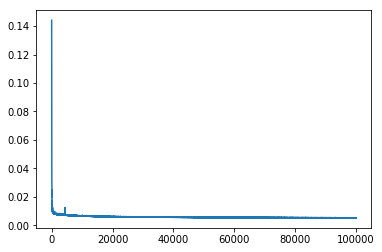

In [16]:
plt.plot(training_loss)

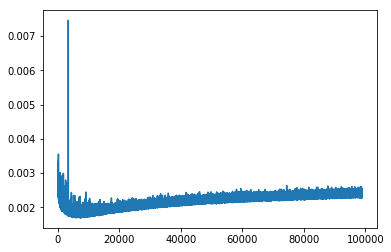

In [20]:
plt.plot(true_MSE[1000:])